In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd

import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

risk_free_rate = 0.03
trial_n = 100

tickers = ['NKE', 'MSFT', 'DIS', 'COST']

#start = '2012-1-1'
#end = '2022-3-1'
start = '2012-1-1'
end = '2022-1-1'


df_close = yf.download(tickers, start, end, interval='1mo')['Close']

df_close.to_csv('./data/df_close.csv')

[*********************100%***********************]  4 of 4 completed


In [2]:
df_close.shape

(120, 4)

In [3]:
df_close.head()

,COST,DIS,MSFT,NKE
Date,,,,
2012-01-01 00:00:00-05:00,82.269997,38.900002,29.530001,25.997499
2012-02-01 00:00:00-05:00,86.059998,41.990002,31.740000,26.980000
2012-03-01 00:00:00-05:00,90.800003,43.779999,32.259998,27.110001
2012-04-01 00:00:00-04:00,88.180000,43.110001,32.020000,27.967501
2012-05-01 00:00:00-04:00,86.389999,45.709999,29.190001,27.045000


In [4]:
df_close.tail()

,COST,DIS,MSFT,NKE
Date,,,,
2021-08-01 00:00:00-04:00,455.489990,181.300003,301.880005,164.740005
2021-09-01 00:00:00-04:00,449.350006,169.169998,281.920013,145.229996
2021-10-01 00:00:00-04:00,491.540009,169.070007,331.619995,167.289993
2021-11-01 00:00:00-04:00,539.380005,144.899994,330.589996,169.240005
2021-12-01 00:00:00-05:00,567.700012,154.889999,336.320007,166.669998


In [5]:
df_close.isnull().sum()

COST    0
DIS     0
MSFT    0
NKE     0
dtype: int64

In [6]:
if df_close.isnull().values.any():
    df_close.fillna(method='ffill', inplace = True) #front fills
    df_close.fillna(method='bfill', inplace = True) #back fills

In [7]:
def plot(df, xlabel, ylabel, title):
    #matplotlib
    ax = df_close.plot(title = title, figsize=(16, 8), ax = None)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axhline(y=0, color = 'black')
    ax.legend(loc='upper left')
    plt.show()

    #plotly
    fig = px.line(df_close, title = title)
    fig.update_layout(xaxis_title=xlabel, yaxis_title=ylabel,showlegend=True, template='seaborn')
    fig.show()

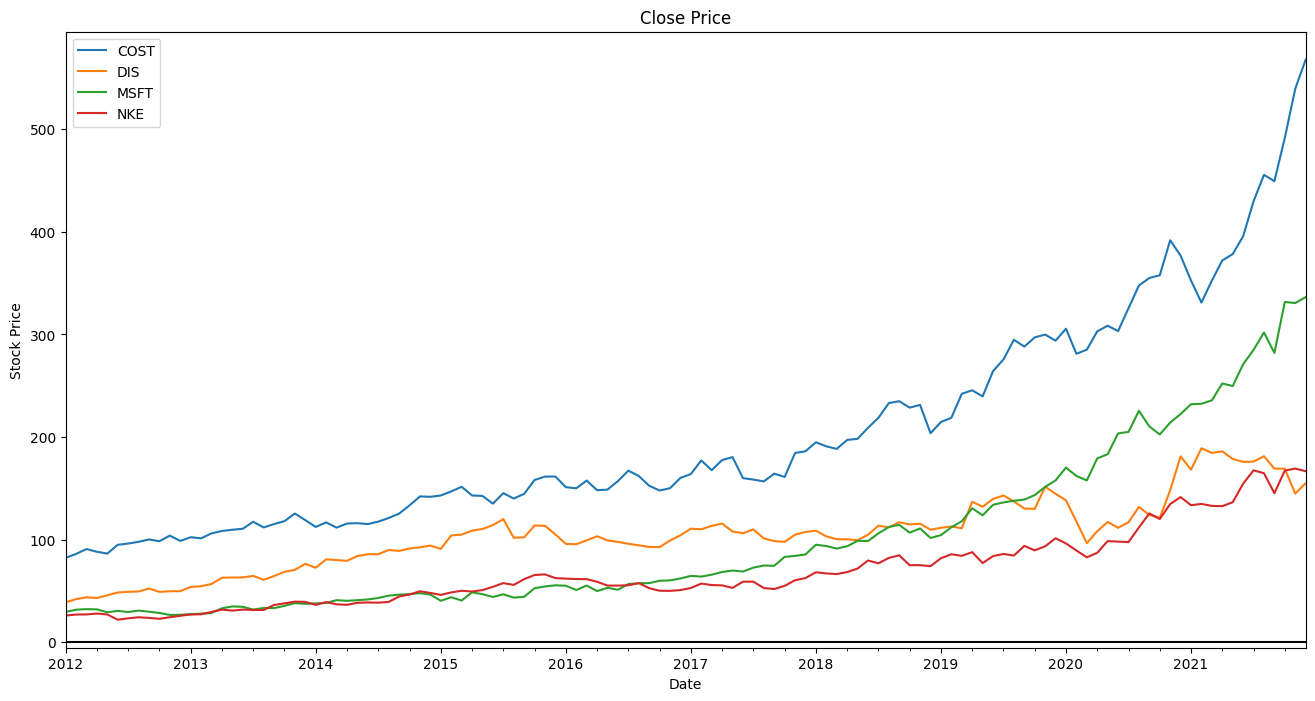

In [8]:
plot(df_close, 'Date', 'Stock Price', 'Close Price')

In [9]:
df_pct_change = df_close.pct_change().iloc[1:] #get rid of last row
df_pct_change.head()

,COST,DIS,MSFT,NKE
Date,,,,
2012-02-01 00:00:00-05:00,0.046068,0.079434,0.074839,0.037792
2012-03-01 00:00:00-05:00,0.055078,0.042629,0.016383,0.004818
2012-04-01 00:00:00-04:00,-0.028855,-0.015304,-0.007439,0.031630
2012-05-01 00:00:00-04:00,-0.020299,0.060311,-0.088382,-0.032985
2012-06-01 00:00:00-04:00,0.099664,0.061037,0.047962,-0.188575


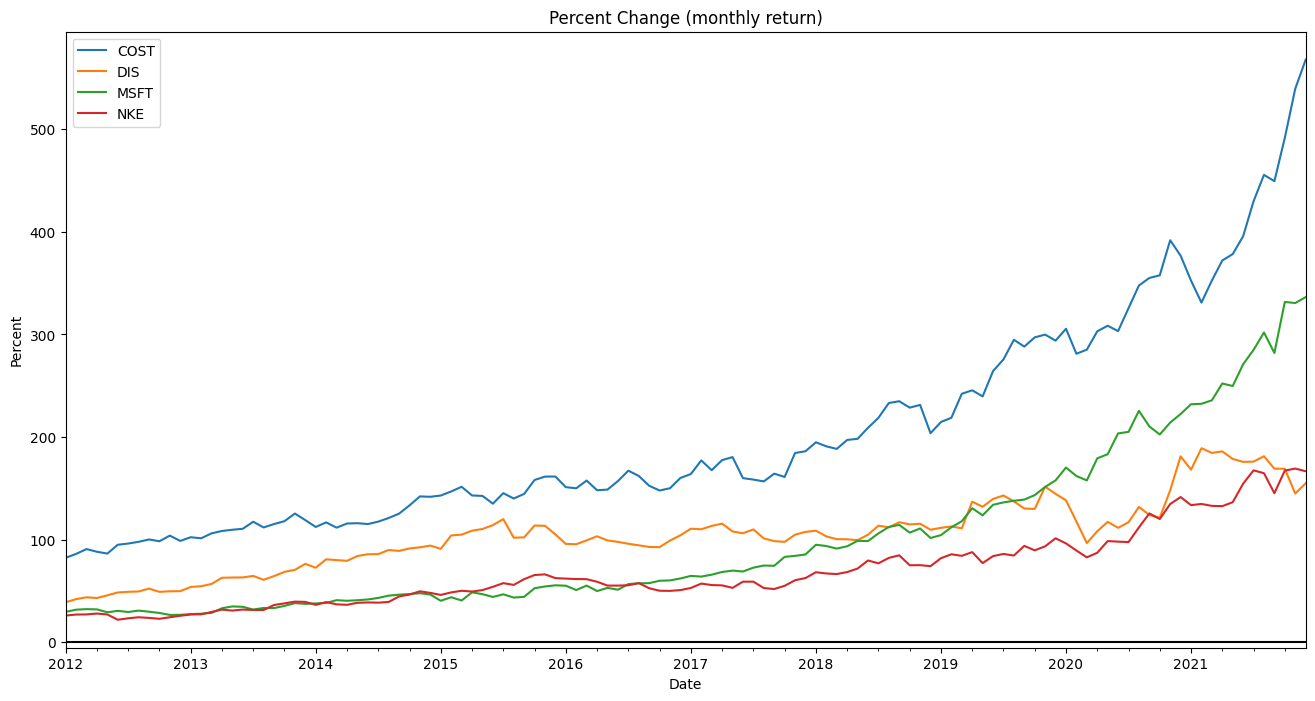

In [10]:
plot(df_pct_change, 'Date', 'Percent', 'Percent Change (monthly return)')

In [11]:
mean_return = df_pct_change.mean() * 12
mean_return

COST    0.210163
DIS     0.166885
MSFT    0.267666
NKE     0.212343
dtype: float64

In [12]:
var_risk = df_pct_change.var() * 12
var_risk

COST    0.027995
DIS     0.055262
MSFT    0.041114
NKE     0.047685
dtype: float64

In [13]:
cov_mat = df_pct_change.cov()*12
cov_mat

,COST,DIS,MSFT,NKE
COST,0.027995,0.010468,0.010946,0.011377
DIS,0.010468,0.055262,0.016682,0.019448
MSFT,0.010946,0.016682,0.041114,0.012376
NKE,0.011377,0.019448,0.012376,0.047685


In [14]:
corr_mat = df_pct_change.corr()
corr_mat

,COST,DIS,MSFT,NKE
COST,1.000000,0.266133,0.322651,0.311372
DIS,0.266133,1.000000,0.349985,0.378852
MSFT,0.322651,0.349985,1.000000,0.279516
NKE,0.311372,0.378852,0.279516,1.000000


In [15]:
fig = px.imshow(corr_mat, title='Correlation Heatmap')
fig.show()

In [16]:
weight = 1/len(tickers)
eq_weights = [weight for i in tickers]
eq_weights

[0.25, 0.25, 0.25, 0.25]

In [17]:
eq_return = eq_weights @ (mean_return)
eq_return

0.21426419041415923

In [18]:
eq_risk = ((eq_weights @ cov_mat) @ eq_weights)**(1/2)
eq_risk

0.14462260526809836

In [19]:
eq_sharpe = (eq_return - risk_free_rate)/eq_risk
eq_sharpe

1.2741036580870198

In [20]:
efficient_frontier_data = []
for trial in tqdm(range(trial_n)):
    t_weight = np.random.random(len(tickers, ))
    t_weights = t_weight/sum(t_weight)
    t_return = t_weights @ (mean_return)
    t_risk = ((t_weights @ cov_mat) @ t_weights)**(1/2)
    t_sharpe = (t_return - risk_free_rate)/t_risk
    efficient_frontier_data.append([t_weights, t_risk, t_return, t_sharpe])

efficient_frontier_data = pd.DataFrame(efficient_frontier_data, columns=['Weights', 'Risk', 'Return', 'Sharpe'])
efficient_frontier_data.head()

100%|██████████| 100/100 [00:00<00:00, 5271.54it/s]


,Weights,Risk,Return,Sharpe
0,"[0.36459181709293925, 0.3469148265571488, 0.14...",0.146097,0.203789,1.189542
1,"[0.07575809339511518, 0.5748885671028128, 0.34...",0.177584,0.205040,0.985673
2,"[0.23930755790142447, 0.30338613627910094, 0.3...",0.147303,0.215798,1.261336
3,"[0.22624046381060509, 0.3746983286134491, 0.32...",0.152735,0.212934,1.197719
4,"[0.1809472919613222, 0.2790092646507888, 0.270...",0.148928,0.214210,1.236905


In [21]:
i_max_sharpe = efficient_frontier_data['Sharpe'].idxmax()
max_sharpe = efficient_frontier_data.iloc[i_max_sharpe, :]
max_sharpe

Weights    [0.4607984347223325, 0.05864662708018622, 0.35...
Risk                                                0.140105
Return                                              0.228384
Sharpe                                              1.415965
Name: 10, dtype: object

In [22]:
i_min_risk = efficient_frontier_data['Risk'].idxmin()
min_risk = efficient_frontier_data.iloc[i_min_risk, :]
min_risk

Weights    [0.39923902792401234, 0.11887742406194236, 0.2...
Risk                                                0.138608
Return                                              0.219162
Sharpe                                               1.36473
Name: 91, dtype: object

In [23]:
i_max_return = efficient_frontier_data['Return'].idxmax()
max_return = efficient_frontier_data.iloc[i_max_return, :]
max_return

Weights    [0.2300918619953717, 0.026924486738757716, 0.7...
Risk                                                0.167986
Return                                              0.251004
Sharpe                                              1.315605
Name: 43, dtype: object

In [24]:
print(eq_risk, eq_return)
print(max_sharpe['Risk'], max_sharpe['Return'])


0.14462260526809836 0.21426419041415923
0.14010490416742094 0.22838362661003628


In [25]:
from plotly import graph_objects as go


def addMarker(fig, x, y, color):
    fig.add_trace(
        go.Scatter(
            x=[x],
            y=[y],
            mode="markers",
            marker_symbol='star',
            marker_size=10,
            marker_color=color
        )
    )


In [26]:
fig = px.scatter(efficient_frontier_data, x='Risk', y='Return', title='Efficient Frontier', color='Risk')
addMarker(fig, max_sharpe['Risk'], max_sharpe['Return'], 'Green')
addMarker(fig, min_risk['Risk'], min_risk['Return'], 'Cyan')
addMarker(fig, max_return['Risk'], max_return['Return'], 'Red')
fig.show()

## Process data for recent past year for same stocks and the spy

In [27]:
tickers = ['NKE', 'MSFT', 'DIS', 'COST']

start = '2022-1-1'
end = '2023-1-1'

df_recent_close = yf.download(tickers, start, end, interval='1d')['Close']
df_recent_close.to_csv('./data/df_recent_close.csv')

df_spy_close = yf.download('SPY', start, end, interval='1d')['Close']
df_spy_close.to_csv('./data/df_spy_close.csv')

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed


## Percent Change for recent past year

In [28]:
recent_pct_change = df_recent_close.pct_change().iloc[1:] #get rid of last row
recent_mean_return = recent_pct_change.mean() * 365
recent_risk = recent_pct_change.var() * 365 

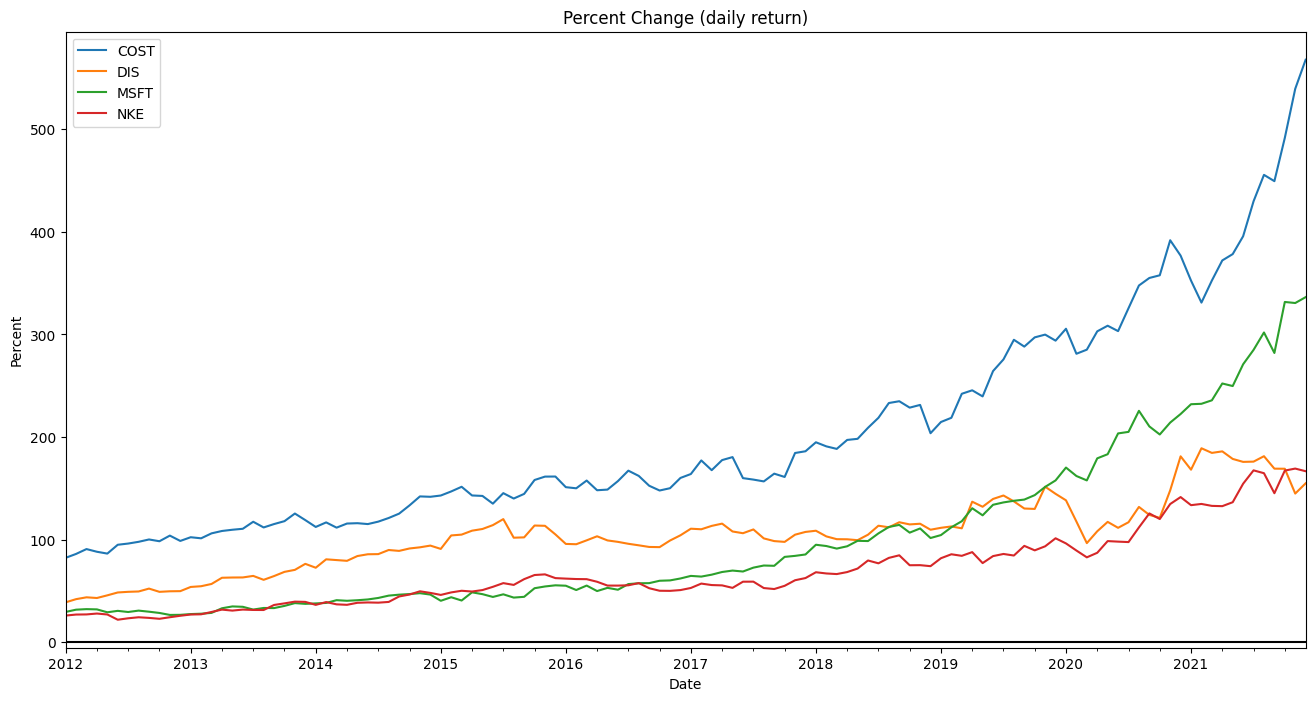

In [29]:
plot(recent_pct_change, 'Date', 'Percent', 'Percent Change (daily return)')

In [30]:
spy_pct_change = df_spy_close.pct_change().iloc[1:] #get rid of last row
spy_mean_return = spy_pct_change.mean() * 365
spy_risk = spy_pct_change.var() * 365

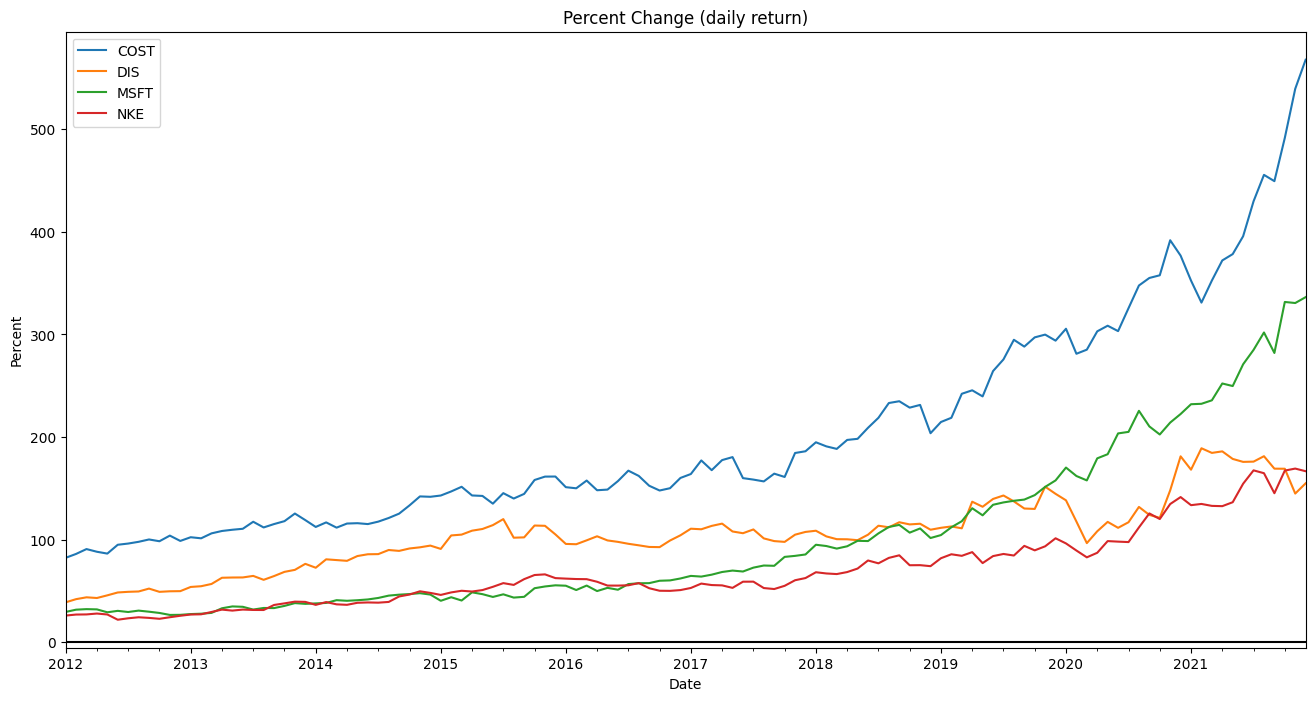

In [31]:
plot(spy_pct_change, 'Date', 'Percent', 'Percent Change (daily return)')

## Cumulative Product Past Recent Year

In [32]:
recent_cumulative_product = recent_pct_change.add(1).cumprod().sub(1)

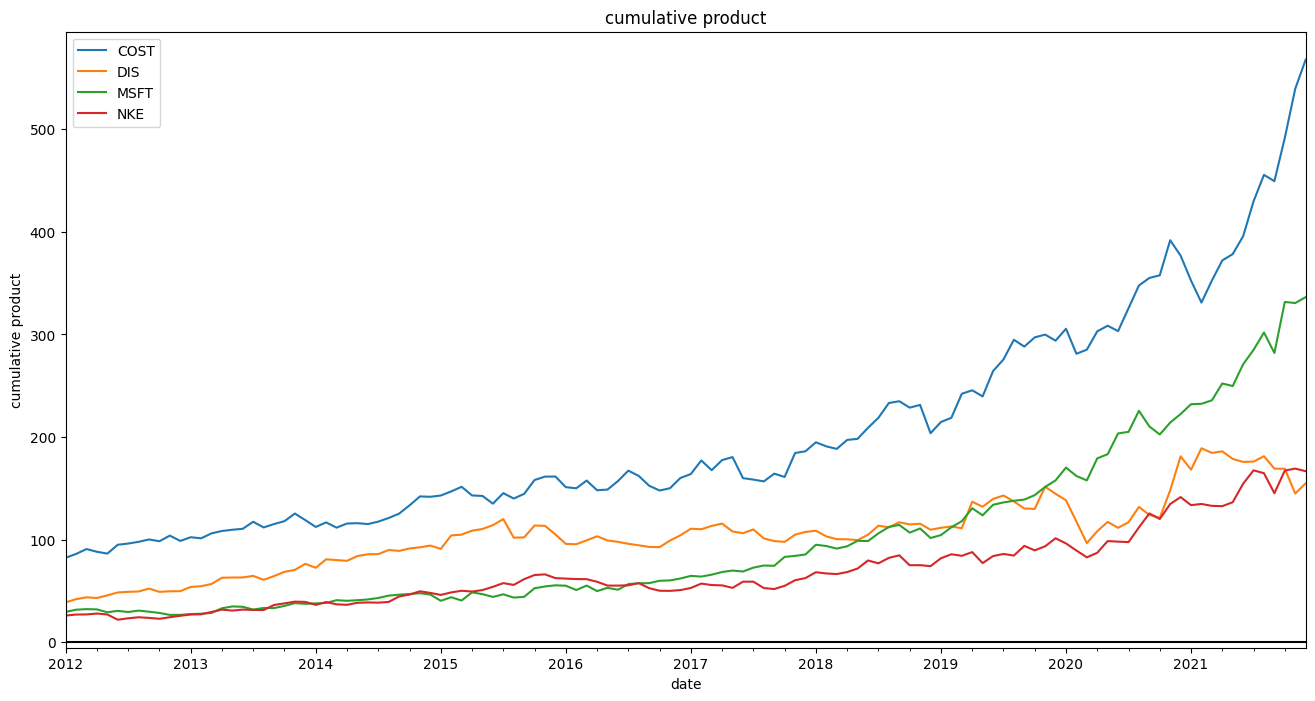

In [33]:
plot(recent_cumulative_product, 'date', 'cumulative product', 'cumulative product' )

In [34]:
spy_cumulative_product = spy_pct_change.add(1).cumprod().sub(1)

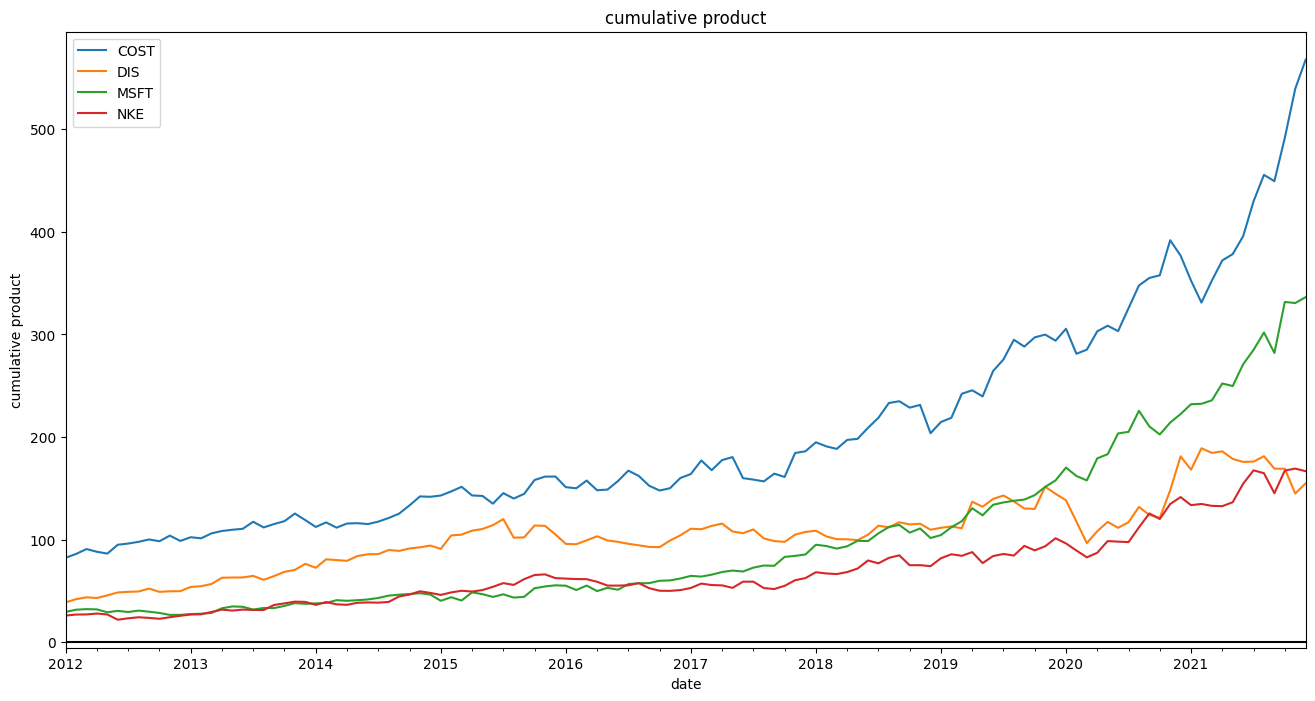

In [35]:
plot(spy_cumulative_product, 'date', 'cumulative product', 'cumulative product')